# Synthetic images

In [3]:
# from functools import lru_cache
# from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product
import numpy as np
import pandas as pd
# from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import xarray as xr
import torch

from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms import Compose
# import pytorch_lightning as pl

from arnet.modeling.learner import Learner
from arnet.dataset import ActiveRegionDataModule, ActiveRegionDataset
from arnet.transforms import get_transform
from captum_helper import get_heatmap, get_heatmaps_synthetic
from cotrain_helper import get_learner_by_query
from paracoord_helper import parallel_coordinates_and_hist
from synthetic import bipole_gaussian, bipole_yeates2020, sweep_constant_images, sweep_Z_list, sweep_learner_and_Z_list
# retrieve = lru_cache(retrieve)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/zeyusun/work/flare-prediction-smarp/arnet/constants.py:22: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  CONSTANTS = get_constants()


In [ ]:
algorithms = ['Original', 'Saliency', 'Deconvolution', 'GuidedBackprop', 'DeepLift', 'LayerGradCam']

## Synthetic image data

In [ ]:
from arnet.transforms import calc_stats
hist = np.load('/home/zeyusun/work/flare-prediction-smarp/datasets/sharp_hist.npy', allow_pickle=True).item()
#func = get_transform('ValueTransform', cfg) if 'ValueTransform' in cfg.DATA.TRANSFORMS else None             
#mean, std = 
calc_stats(hist['hist'], hist['bins'], func=None)                                                

(-0.02334314373614411, 93.78056679862786)

MDI/HMI maximum 2000 Gs. Standard deviation ~100. So the transformed input has maximum magnitutde 20.

In [54]:
dataset = 'fused_sharp'
prob_list = []
for val_split in range(5):
    prob_list.append([])
    for test_split in range(5):
        learner = get_learner_by_query(f'cv/base/{dataset}/0/{val_split}/{test_split}/CNN')
        learner.eval()
        learner.to('cuda:1')
        const, probs = sweep_constant_images(learner, lim=10)
        prob_list[-1].append(probs)

dict_values(['cv', 'base', 'fused_sharp', '0', '0', '0', 'CNN'])


/home/zeyusun/work/flare-prediction-smarp/notebooks/synthetic.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(output)[:, 1].tolist()


dict_values(['cv', 'base', 'fused_sharp', '0', '0', '1', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '0', '2', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '0', '3', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '0', '4', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '1', '0', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '1', '1', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '1', '2', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '1', '3', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '1', '4', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '2', '0', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '2', '1', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '2', '2', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '2', '3', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '2', '4', 'CNN'])
dict_values(['cv', 'base', 'fused_sharp', '0', '3', '0', 'CNN'])
dict_values(['cv', 'base'

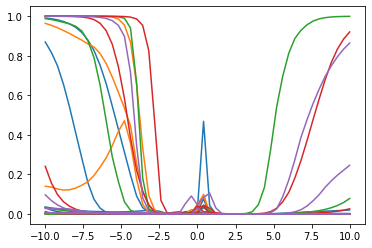

In [59]:
for val_split in range(5):
    for test_split in range(5):
        plt.plot(const,
                 prob_list[val_split][test_split],
                 color=f'C{val_split}',
                )
plt.ylim([-0.05, 1.05])
plt.show()

## Unipoles

## Bipoles

In [5]:
x = y = np.linspace(-10.0, 10.0, 128)
X, Y = np.meshgrid(x, y)
XY = np.stack((X, Y), axis=-1)

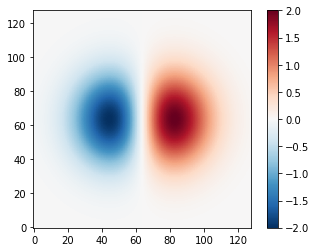

In [6]:
Z = bipole_gaussian(XY, B0=10, rho=1, gamma=0, sigma=3)
plt.imshow(Z, origin='lower', cmap='RdBu_r')
plt.colorbar()

In [ ]:
B0_list = np.arange(1, 18, 2)
rho_list = np.arange(1, 15, 2)
gamma_list = np.pi * np.arange(0, 2, 0.2)
sigma_list = np.arange(1, 4, 1)

params = list(product(B0_list, rho_list, gamma_list, sigma_list))
names = ['B0', 'rho', 'gamma', 'sigma']

df, Z_list = sweep_learner_and_Z_list(bipole_gaussian, XY, params, names)

array([[<AxesSubplot:title={'center':'B0'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'gamma'}>, <AxesSubplot:>]],
      dtype=object)

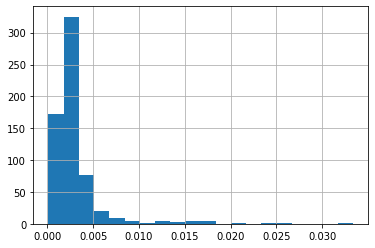

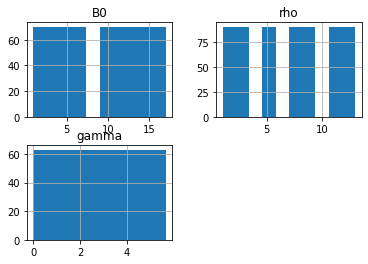

In [11]:
(df[[c for c in df.columns if c[:5] == 'prob_']]
 .describe()
 .style
 .background_gradient(axis=1)
)
df['prob'].hist(bins=20)
df[names].hist()

In [ ]:
df_pos = df[df['prob'] > 0.5]
Z_list_pos = [Z_list[i] for i in df_pos.index]
len(df_pos)

In [ ]:
heatmaps = get_heatmaps_synthetic(Z_list_pos, algorithms, learner)

In [ ]:
zmax = [np.percentile(np.abs(i), 99)
        for i in heatmaps.values()]
for i, Z in enumerate(Z_list_pos):
    m = len(algorithms)
    plt.figure(figsize=(20,3))
    for j, algorithm in enumerate(algorithms):
        plt.subplot(1, len(algorithms), j+1)
        cmap = 'gray' if j == 0 else 'RdBu_r'
        heatmap = heatmaps[algorithm][i].squeeze()
        if algorithm == 'LayerGradCam':
            heatmap = np.abs(heatmap)
        plt.imshow(heatmap, vmin=-zmax[j], vmax=zmax[j], cmap=cmap)
        plt.title(algorithm)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

This bipole dataset can be used to diagnose CNN and compare CNN.
* To diagnose, pick the positive predictions and look into their attribution map. Are the predictions sensitive to (or activated by) the angles? Magnetude? Polarity separation?
* To compare, use parallel coordinates, in which predicted probabilities by different models are associated with the characteristics of the test image. We may find many models respond to a pattern while a few others don't.
    * We will also want to look into the attribution map by different models. Predicted probability is only a number, whereas attribution maps can reveal a lot more. Some models may have unique attribution map among others.

CNN tend to give highly confident results (predictions with high resolution). The same is also true for LSTM. This is because of Cross Entropy loss. Only nonambiguous prediction with probability close to 0 or 1 is achieves a low loss value. This may makes the deep learning models overly confident by overfitting on the training set. In reality, some ambiguity is desired because (1) the data itself may not reveal the future as accurately, and (2) even though the data contains all the information needed for prediction, they may be presented in a convoluted way, in which case more data are required to exploit the full capacity of deep learning models.

In [15]:
intervals = {
    'B0': 2,
    'rho': 2,
    'gamma': np.pi * 0.2,
    #'sigma': 1,
}
df_jitter = df.copy()
for k in intervals:
    df_jitter[k] += intervals[k] * np.random.rand(len(df))

In [13]:
df.describe()

,B0,rho,gamma,prob_0_0,prob_0_1,prob_0_2,prob_0_3,prob_0_4,prob_1_0,prob_1_1,...,prob_3_1,prob_3_2,prob_3_3,prob_3_4,prob_4_0,prob_4_1,prob_4_2,prob_4_3,prob_4_4,prob
count,630.000000,630.000000,630.000000,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,630.000000,...,6.300000e+02,630.000000,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,630.000000,630.000000,630.000000
mean,9.000000,7.000000,2.827433,6.196763e-04,8.340269e-03,2.472426e-05,4.749857e-05,1.388595e-04,2.723730e-04,0.003724,...,3.719870e-04,0.002058,4.143711e-05,8.364456e-06,9.264267e-06,6.347386e-04,2.708267e-03,0.000412,0.004948,0.003051
std,5.168081,4.003178,1.806142,4.818887e-04,1.633555e-02,9.787475e-05,1.010408e-04,2.148844e-04,3.294426e-04,0.002215,...,6.560960e-04,0.004830,8.284218e-05,1.076455e-05,2.159000e-05,1.640791e-03,1.980129e-02,0.000361,0.002836,0.003332
min,1.000000,1.000000,0.000000,8.617785e-07,2.465118e-10,1.376413e-08,2.116877e-09,3.950839e-07,8.291398e-07,0.000381,...,1.198878e-09,0.000001,3.065996e-08,4.088989e-09,6.860311e-11,2.012471e-08,3.153790e-08,0.000105,0.000074,0.000111
25%,5.000000,3.000000,1.256637,9.674319e-05,3.877945e-05,6.793379e-07,5.418179e-06,2.420521e-05,1.326391e-04,0.001462,...,4.477403e-05,0.000149,4.783567e-06,1.593901e-06,2.837937e-07,2.990540e-05,2.052539e-07,0.000241,0.002250,0.001614
50%,9.000000,7.000000,2.827433,6.359934e-04,4.358203e-03,1.794527e-06,2.587372e-05,5.468356e-05,2.011937e-04,0.003905,...,1.351478e-04,0.000419,9.350269e-06,3.585182e-06,2.260417e-06,8.034683e-05,7.179130e-06,0.000251,0.005788,0.002529
75%,13.000000,11.000000,4.398230,1.073709e-03,1.036252e-02,6.713850e-06,5.548911e-05,1.458130e-04,3.292565e-04,0.005792,...,4.299880e-04,0.000976,3.654480e-05,1.068231e-05,7.462262e-06,4.013051e-04,2.704708e-04,0.000399,0.007094,0.003154
max,17.000000,13.000000,5.654867,2.147700e-03,2.317472e-01,1.397088e-03,1.623856e-03,1.512392e-03,3.803724e-03,0.007987,...,6.060141e-03,0.042951,6.394440e-04,5.379899e-05,2.034130e-04,1.373263e-02,2.847944e-01,0.002430,0.015711,0.033328


In [16]:
df_jitter.describe()

,B0,rho,gamma,prob_0_0,prob_0_1,prob_0_2,prob_0_3,prob_0_4,prob_1_0,prob_1_1,...,prob_3_1,prob_3_2,prob_3_3,prob_3_4,prob_4_0,prob_4_1,prob_4_2,prob_4_3,prob_4_4,prob
count,630.000000,630.000000,630.000000,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,630.000000,...,6.300000e+02,630.000000,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,6.300000e+02,630.000000,630.000000,630.000000
mean,9.992884,8.044474,3.151311,6.196763e-04,8.340269e-03,2.472426e-05,4.749857e-05,1.388595e-04,2.723730e-04,0.003724,...,3.719870e-04,0.002058,4.143711e-05,8.364456e-06,9.264267e-06,6.347386e-04,2.708267e-03,0.000412,0.004948,0.003051
std,5.219684,4.037071,1.816415,4.818887e-04,1.633555e-02,9.787475e-05,1.010408e-04,2.148844e-04,3.294426e-04,0.002215,...,6.560960e-04,0.004830,8.284218e-05,1.076455e-05,2.159000e-05,1.640791e-03,1.980129e-02,0.000361,0.002836,0.003332
min,1.005871,1.067269,0.005199,8.617785e-07,2.465118e-10,1.376413e-08,2.116877e-09,3.950839e-07,8.291398e-07,0.000381,...,1.198878e-09,0.000001,3.065996e-08,4.088989e-09,6.860311e-11,2.012471e-08,3.153790e-08,0.000105,0.000074,0.000111
25%,5.569799,4.663910,1.599479,9.674319e-05,3.877945e-05,6.793379e-07,5.418179e-06,2.420521e-05,1.326391e-04,0.001462,...,4.477403e-05,0.000149,4.783567e-06,1.593901e-06,2.837937e-07,2.990540e-05,2.052539e-07,0.000241,0.002250,0.001614
50%,10.169453,8.009319,3.131510,6.359934e-04,4.358203e-03,1.794527e-06,2.587372e-05,5.468356e-05,2.011937e-04,0.003905,...,1.351478e-04,0.000419,9.350269e-06,3.585182e-06,2.260417e-06,8.034683e-05,7.179130e-06,0.000251,0.005788,0.002529
75%,14.497334,11.571639,4.711520,1.073709e-03,1.036252e-02,6.713850e-06,5.548911e-05,1.458130e-04,3.292565e-04,0.005792,...,4.299880e-04,0.000976,3.654480e-05,1.068231e-05,7.462262e-06,4.013051e-04,2.704708e-04,0.000399,0.007094,0.003154
max,18.972209,14.979260,6.280133,2.147700e-03,2.317472e-01,1.397088e-03,1.623856e-03,1.512392e-03,3.803724e-03,0.007987,...,6.060141e-03,0.042951,6.394440e-04,5.379899e-05,2.034130e-04,1.373263e-02,2.847944e-01,0.002430,0.015711,0.033328


In [ ]:
#fig = px.parallel_coordinates(df, color='prob')
#fig = px.parallel_categories(df.sample(n=100), color='prob') # color is also discrete
fig = parallel_coordinates_and_hist(
    df_jitter,
    dimensions=[c for c in df.columns if not c.startswith('prob_')],
    color='prob',
    color_continuous_scale=px.colors.sequential.Turbo)
fig.update_layout(height=600)
fig

## Bipoles (Yeates 2020)

In [13]:
x = y = np.linspace(-10.0, 10.0, 128)
X, Y = np.meshgrid(x, y)
XY = np.stack((X, Y), axis=-1)

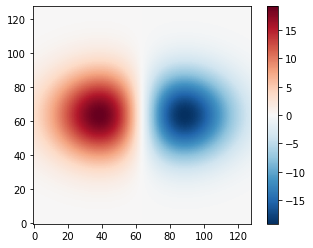

In [18]:
Z = bipole_yeates2020(XY, B0=80, rho=10, gamma=0*np.pi, a=0.56)
plt.imshow(Z, origin='lower', cmap='RdBu_r')
plt.colorbar()

In [19]:
B0_list = np.arange(10, 80, 10)
rho_list = np.arange(1, 15, 2)
gamma_list = np.pi * np.arange(0, 2, 0.2)

params = list(product(B0_list, rho_list, gamma_list))
names = ['B0', 'rho', 'gamma']

df, Z_list = sweep_learner_and_Z_list(bipole_yeates2020, XY, params, names)

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '0', '0', 'CNN'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
200 2021-09-10 18:09:23.430000+00:00                base


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '0', '1', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '0', '3', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '0', '4', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '1', '0', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '1', '1', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '1', '2', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '1', '3', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '1', '4', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '2', '0', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '2', '1', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '2', '2', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '2', '3', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '2', '4', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '3', '0', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '3', '1', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '3', '2', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '3', '3', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '3', '4', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '4', '0', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '4', '1', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '4', '2', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '4', '3', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

dict_values(['cv', 'base', 'sharp', '0', '4', '4', 'CNN'])


  0%|          | 0/31 [00:00<?, ?it/s]

In [22]:
df_pos = df[df['prob'] > 0.5]
Z_list_pos = [Z_list[i] for i in df_pos.index]
print(len(df_pos))

24


In [23]:
(df[[c for c in df.columns if c[:5] == 'prob_']]
 .describe()
 .style
 .background_gradient(axis=1)
)
# df['prob'].hist(bins=20)

,prob_0_0,prob_0_1,prob_0_2,prob_0_3,prob_0_4,prob_1_0,prob_1_1,prob_1_2,prob_1_3,prob_1_4,prob_2_0,prob_2_1,prob_2_2,prob_2_3,prob_2_4,prob_3_0,prob_3_1,prob_3_2,prob_3_3,prob_3_4,prob_4_0,prob_4_1,prob_4_2,prob_4_3,prob_4_4
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,0.379831,0.126780,0.148323,0.048868,0.194678,0.187967,0.204155,0.165430,0.164566,0.093133,0.470448,0.393011,0.005882,0.039406,0.164639,0.015525,0.010012,0.195514,0.013147,0.026212,0.082704,0.034670,0.003185,0.076192,0.016721
std,0.440534,0.271405,0.334531,0.191119,0.346930,0.359797,0.351942,0.302849,0.328978,0.255655,0.455476,0.429346,0.040123,0.112435,0.321914,0.102319,0.071414,0.341770,0.078706,0.134176,0.257287,0.134897,0.028206,0.200790,0.038918
min,0.000001,0.000000,0.000000,0.000000,0.000001,0.000002,0.000476,0.000035,0.000000,0.000000,0.000023,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000010
25%,0.001524,0.000004,0.000003,0.000000,0.000152,0.000220,0.002349,0.002745,0.000773,0.000009,0.005170,0.008752,0.000004,0.001200,0.000104,0.000000,0.000000,0.000502,0.000003,0.000000,0.000001,0.000004,0.000000,0.000339,0.000503
50%,0.071332,0.001515,0.000038,0.000002,0.002299,0.001502,0.009605,0.010849,0.003257,0.000087,0.286253,0.126931,0.000099,0.008832,0.001852,0.000003,0.000025,0.006414,0.000023,0.000002,0.000024,0.000142,0.000002,0.001689,0.003779
75%,0.978147,0.052524,0.004768,0.000110,0.183836,0.068333,0.180406,0.138302,0.070441,0.002735,0.999956,0.965262,0.000593,0.020851,0.088836,0.000178,0.000524,0.201849,0.000181,0.000041,0.000789,0.001868,0.000043,0.020325,0.011423
max,1.000000,0.999912,1.000000,0.998657,0.999999,1.000000,0.999998,0.999933,0.999999,0.999871,1.000000,1.000000,0.566993,0.906736,1.000000,0.999254,0.880333,1.000000,0.856711,0.995068,1.000000,0.967461,0.516507,0.993292,0.289799


In [ ]:
algorithms = ['Original',
              #'Saliency',
              #'Deconvolution',
              'GuidedBackprop',
              'IntegratedGradients',
              'DeepLift',
              'LayerGradCam'
             ]
dataset, val_split, test_split = 'sharp', 0, 0
learner = get_learner_by_query(
    f'cv/base/{dataset}/0/{val_split}/{test_split}/CNN',
    eval_mode=True,
    device='cuda:1',
)
heatmaps = get_heatmaps_synthetic(Z_list_pos, algorithms, learner)
zmax = [np.percentile(np.abs(i), 99)
        for i in heatmaps.values()]

In [ ]:
for i, Z in enumerate(Z_list_pos):
    m = len(algorithms)
    plt.figure(figsize=(16,2.4))
    for j, algorithm in enumerate(algorithms):
        plt.subplot(1, len(algorithms), j+1)
        cmap = 'gray' if j == 0 else 'RdBu_r'
        heatmap = heatmaps[algorithm][i].squeeze()
        if algorithm == 'LayerGradCam':
            heatmap = np.abs(heatmap)
        plt.imshow(heatmap, vmin=-zmax[j], vmax=zmax[j], cmap=cmap)
        #plt.axis('off')
        plt.title(algorithm)
        plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'syn/{i}')
    plt.show()

Hypothesis: A strong and concentrated negative pole is more likely to flare.